# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [161]:
path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
path = '/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/장애인콜택시 대기시간 예측/'

#### 3) 데이터 읽어오기

In [215]:
taxi = pd.read_csv(path + 'open_data.csv')
weather = pd.read_csv(path + 'weather.csv')

In [165]:
taxi.tail()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
2917,2022-12-27,669,5635,4654,44.4,2198,8178
2918,2022-12-28,607,5654,4648,44.8,2161,7882
2919,2022-12-29,581,5250,4247,52.5,2229,8433
2920,2022-12-30,600,5293,4200,38.3,2183,8155
2921,2022-12-31,263,2167,1806,33.7,2318,9435


In [216]:
weather.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84
4017,2022-12-31,-4.4,-4.4,0.0,66.0,66.0,0.00


#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [167]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [168]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [169]:
taxi = taxi.rename(columns={'기준일': 'Date', '차량운행': 'Vehicle Operation', '접수건': 'Service Requests', '탑승건': 'Boardings', '평균대기시간': 'Average Wait Time', '평균요금': 'Average Fare', '평균승차거리': 'Average Distance Traveled'})


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [170]:
taxi_copy = taxi.copy()

In [171]:
# 'Date'열을 datetime 자료형으로 변환
taxi_copy['Date'] = pd.to_datetime(taxi_copy['Date'])

In [172]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2922 non-null   datetime64[ns]
 1   Vehicle Operation          2922 non-null   int64         
 2   Service Requests           2922 non-null   int64         
 3   Boardings                  2922 non-null   int64         
 4   Average Wait Time          2922 non-null   float64       
 5   Average Fare               2922 non-null   int64         
 6   Average Distance Traveled  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


In [173]:
# 'Date'에서 '요일', '주차', '월', '연도' 정보 추출하여 새로운 열 추가
taxi_copy['Day of Week'] = taxi_copy['Date'].dt.day_name()
taxi_copy['Week'] = taxi_copy['Date'].dt.week
taxi_copy['Month'] = taxi_copy['Date'].dt.month
taxi_copy['Year'] = taxi_copy['Date'].dt.year

<ipython-input-173-8121619e1622>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  taxi_copy['Week'] = taxi_copy['Date'].dt.week


In [174]:
taxi_copy.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022
2921,2022-12-31,263,2167,1806,33.7,2318,9435,Saturday,52,12,2022


In [175]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2922 non-null   datetime64[ns]
 1   Vehicle Operation          2922 non-null   int64         
 2   Service Requests           2922 non-null   int64         
 3   Boardings                  2922 non-null   int64         
 4   Average Wait Time          2922 non-null   float64       
 5   Average Fare               2922 non-null   int64         
 6   Average Distance Traveled  2922 non-null   int64         
 7   Day of Week                2922 non-null   object        
 8   Week                       2922 non-null   int64         
 9   Month                      2922 non-null   int64         
 10  Year                       2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 2

### (2) 일별

In [176]:
pip install koreanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

def plot_bivariate_analysis(df, groupby_col, analysis_col):
    """
    이변량 관계를 시각화하는 함수
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    groupby_col : str
        그룹화할 기준 열의 컬럼명
    analysis_col : str
        분석할 열의 컬럼명
    """
    # 그룹화하여 분석할 데이터프레임 생성
    grouped_df = df.groupby([groupby_col])[analysis_col].sum().reset_index()
    
    # 시각화
    plt.figure(figsize=(15,10))
    sns.lineplot(data=grouped_df, x=groupby_col, y=analysis_col)
    plt.xlabel(groupby_col)
    plt.ylabel(analysis_col)
    plt.title(f"{groupby_col}별 {analysis_col} 변화")
    plt.show()


* 차량 운행수

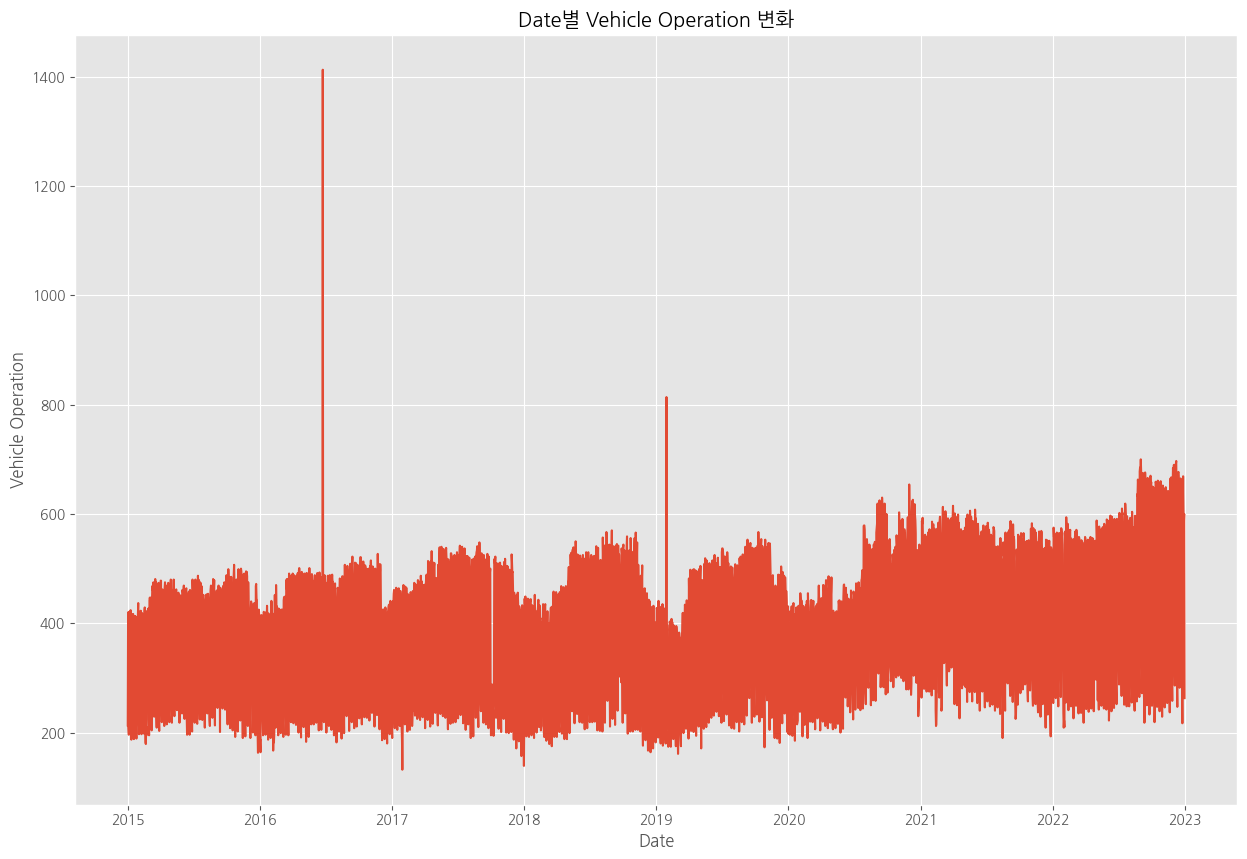

In [178]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Vehicle Operation')

taxi = taxi.rename(columns={'기준일': 'Date', '차량운행': 'Vehicle Operation', '접수건': 'Service Requests', '탑승건': 'Boardings', '평균대기시간': 'Average Wait Time', '평균요금': 'Average Fare', '평균승차거리': 'Average Distance Traveled'})


* 접수건, 탑승건

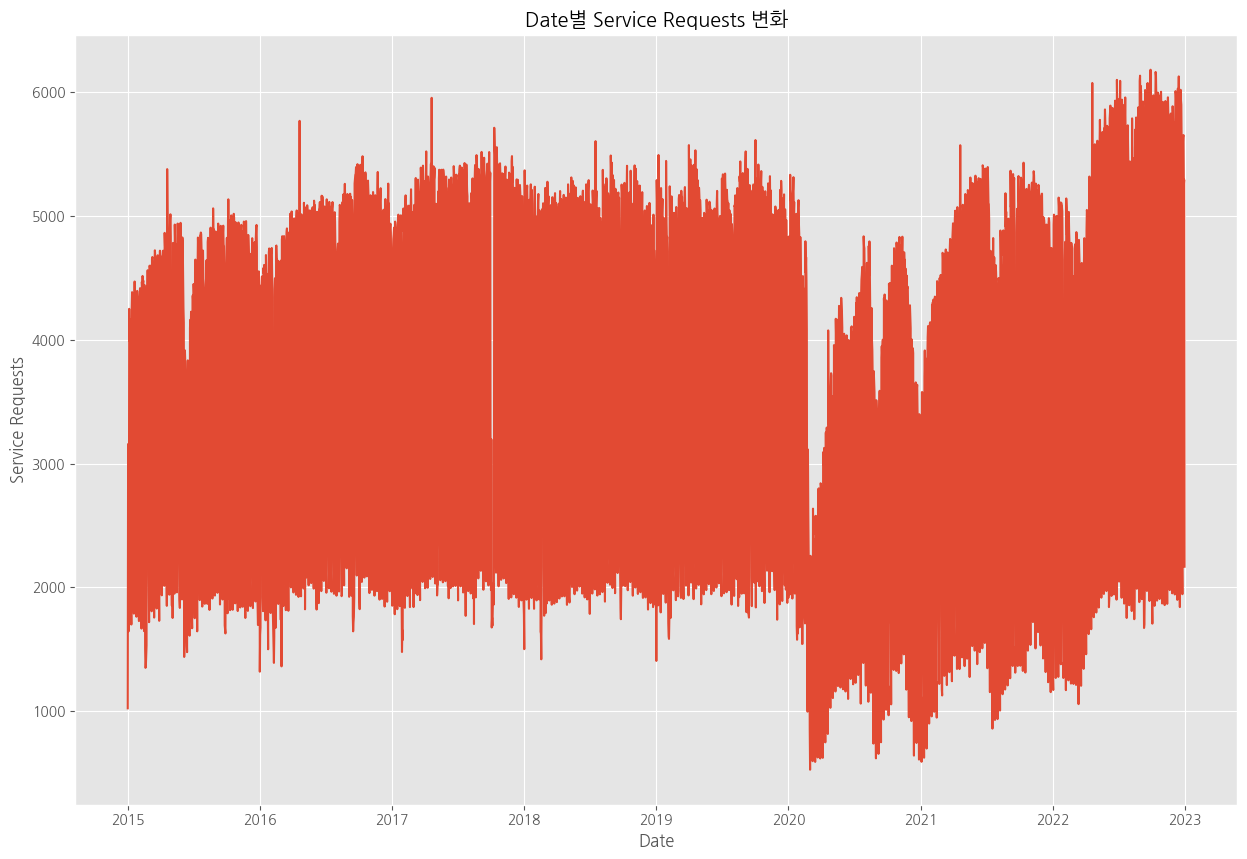

In [179]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Service Requests')

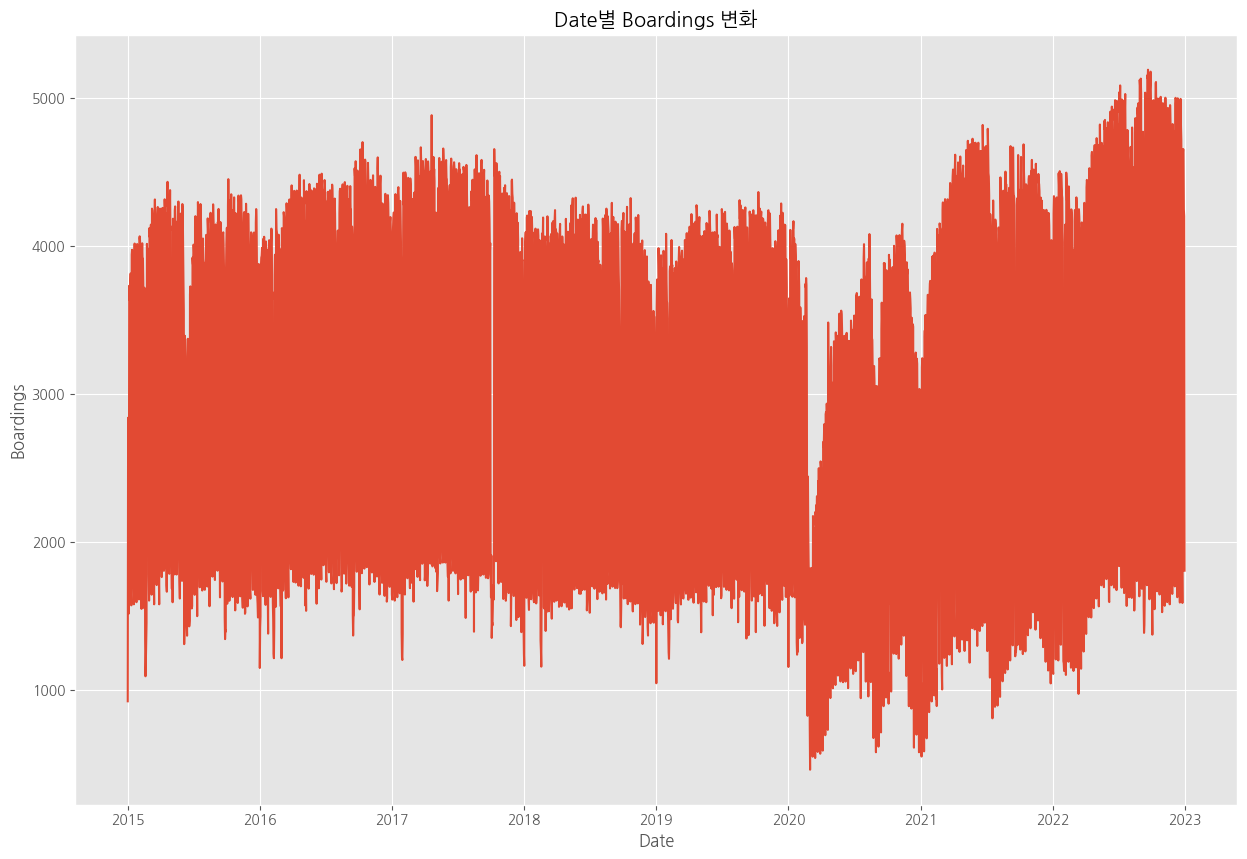

In [180]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Boardings')

* 대기시간

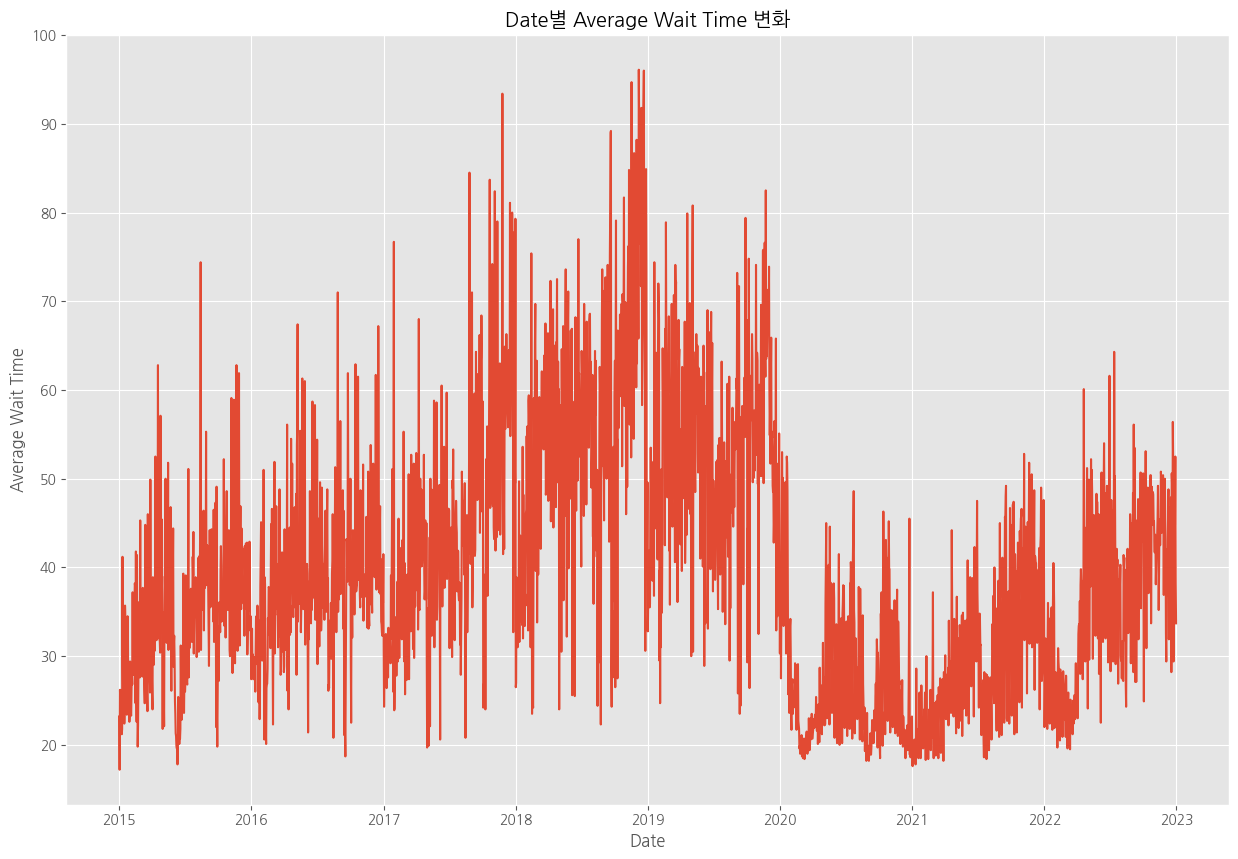

In [181]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Wait Time')


* 운임

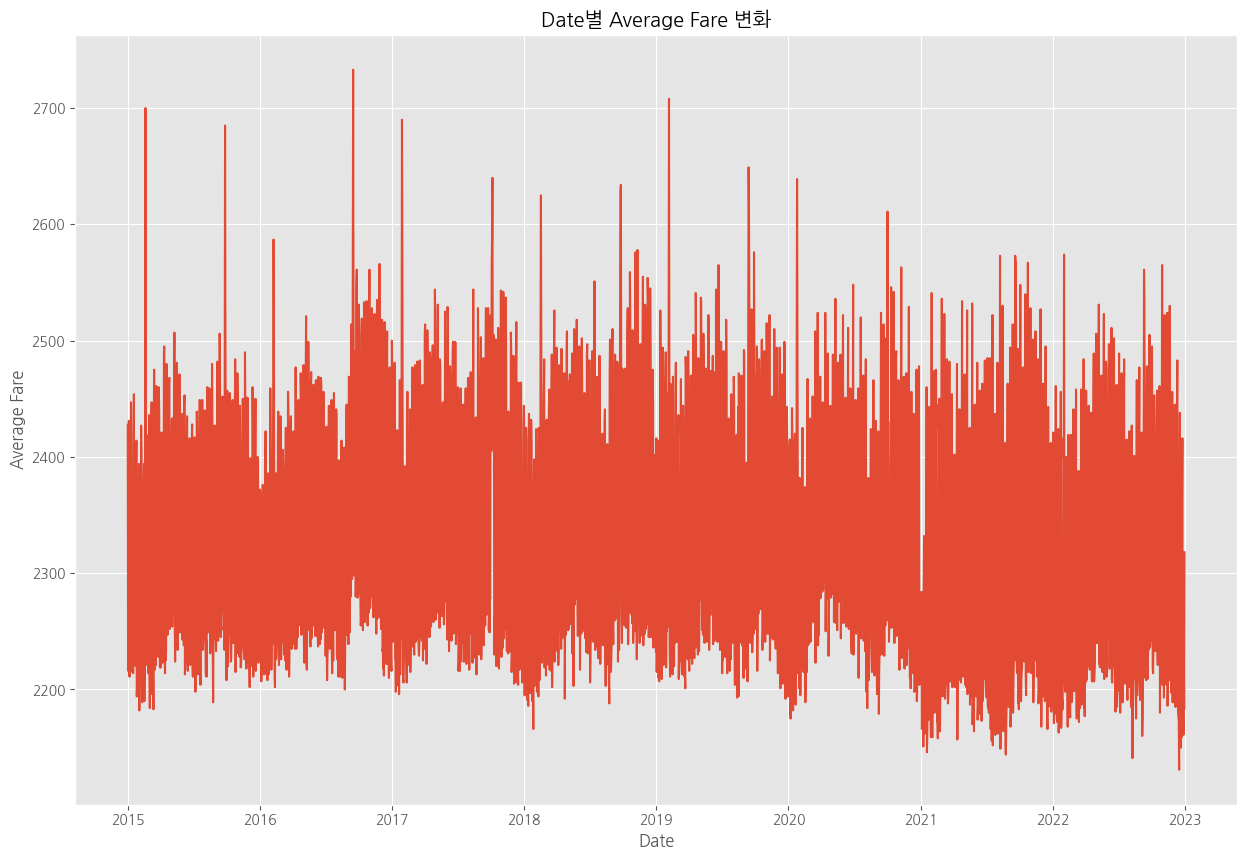

In [182]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Fare')


* 이동거리

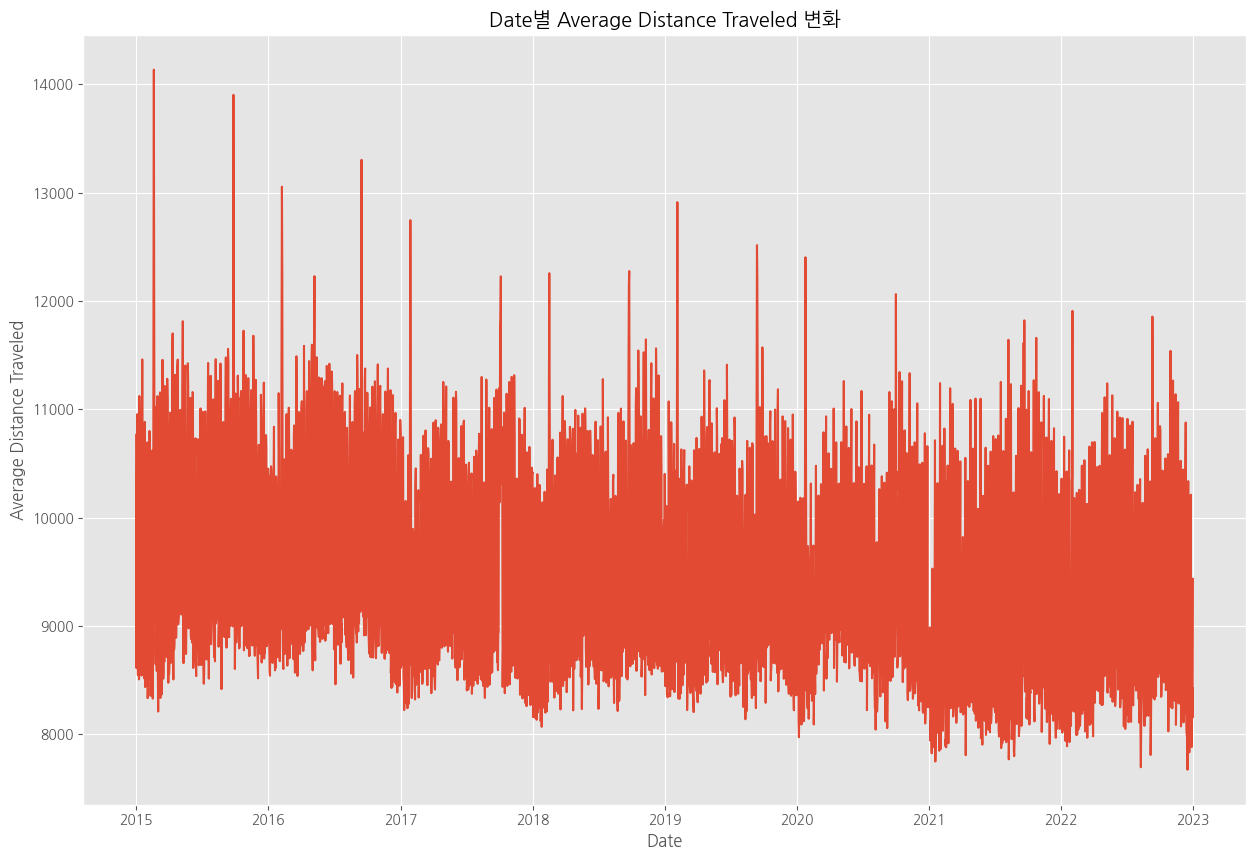

In [183]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Distance Traveled')


In [184]:
taxi_copy.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022
2921,2022-12-31,263,2167,1806,33.7,2318,9435,Saturday,52,12,2022


### (3) 요일별

In [185]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

def plot_barplot_analysis(df, groupby_col, analysis_col):
    """
    이변량 관계를 시각화하는 함수
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    groupby_col : str
        그룹화할 기준 열의 컬럼명
    analysis_col : str
        분석할 열의 컬럼명
    """
    # 그룹화하여 분석할 데이터프레임 생성
    grouped_df = df.groupby([groupby_col])[analysis_col].sum().reset_index()
    
    # 시각화
    plt.figure(figsize=(15,10))
    sns.barplot(data=grouped_df, x=groupby_col, y=analysis_col)
    plt.xticks(rotation=0)
    plt.xlabel(groupby_col)
    plt.ylabel(analysis_col)
    plt.title(f"{groupby_col}별 {analysis_col} 변화")
    plt.show()


* 차량 운행수

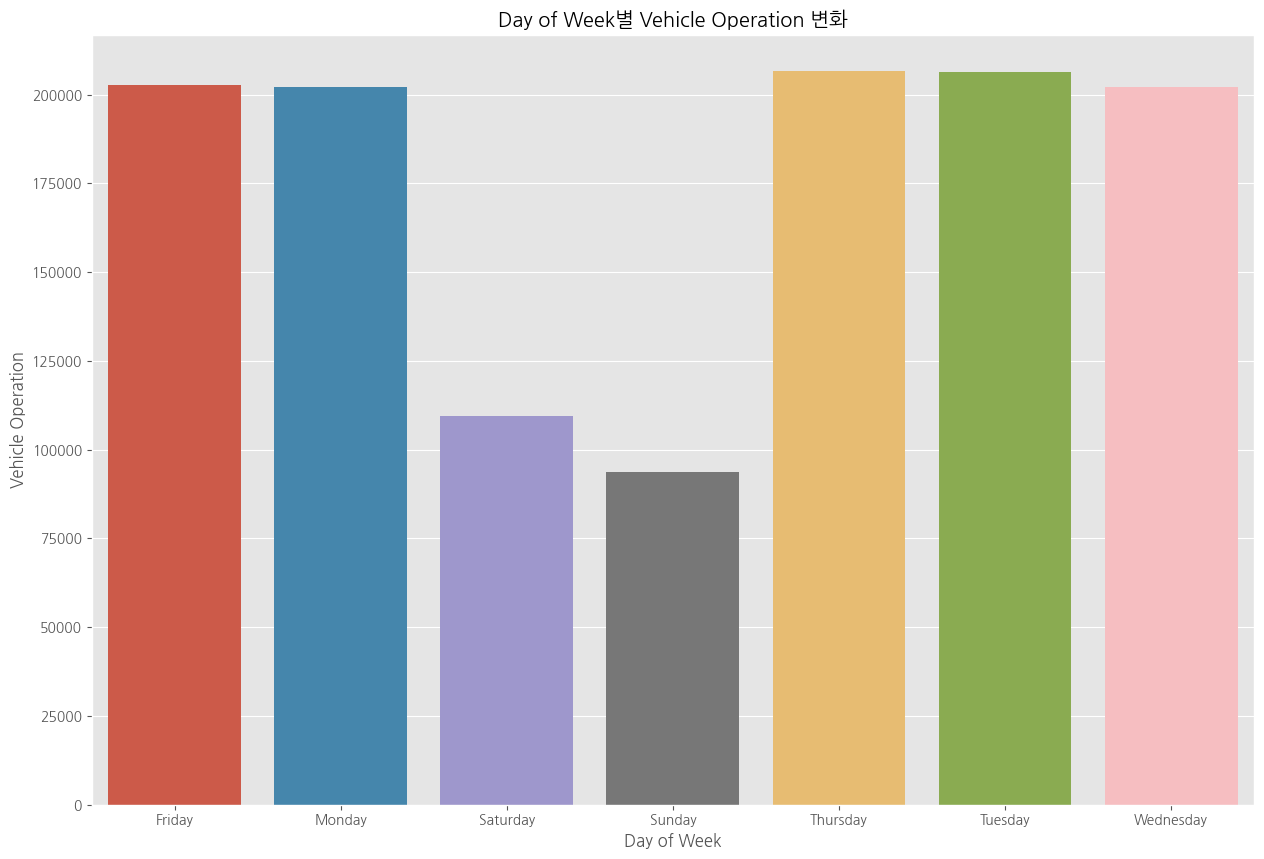

In [186]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Vehicle Operation')


* 접수건, 탑승건

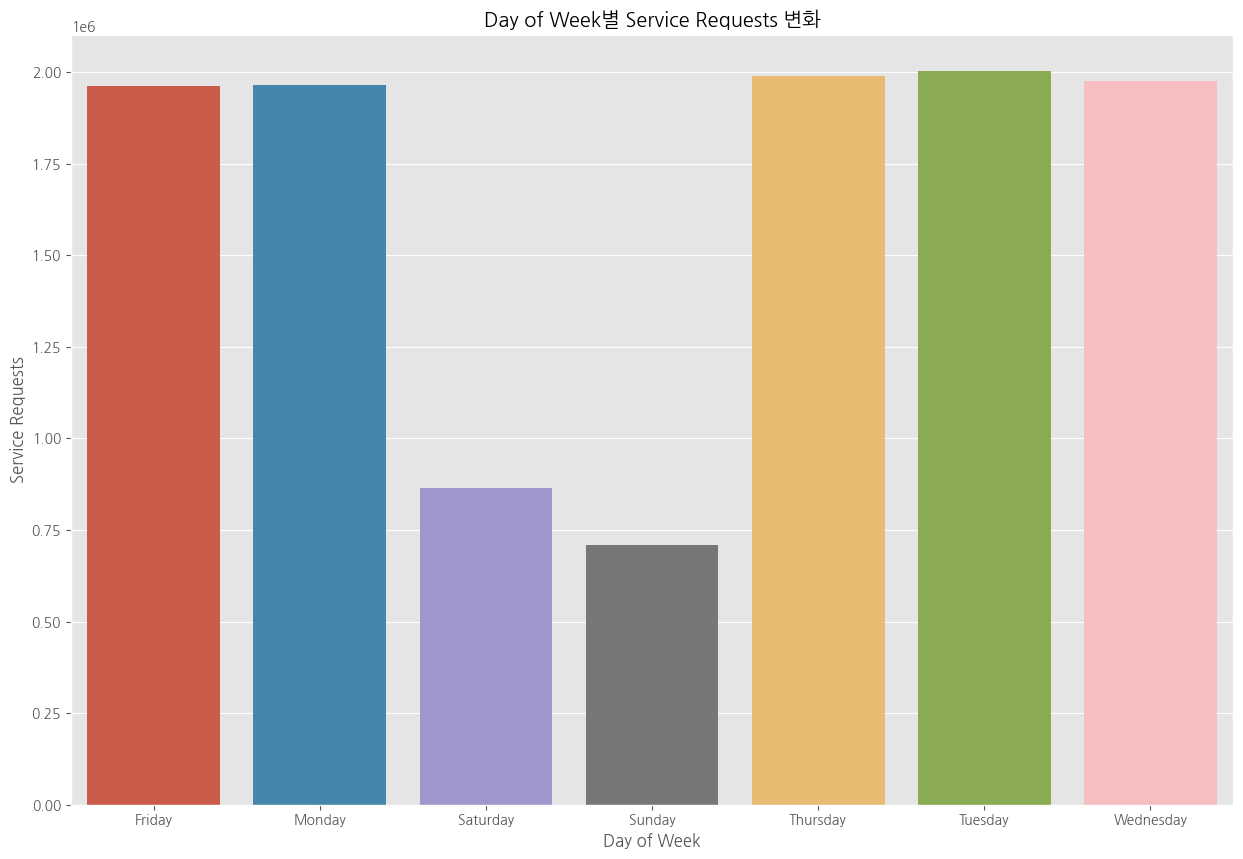

In [187]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Service Requests')


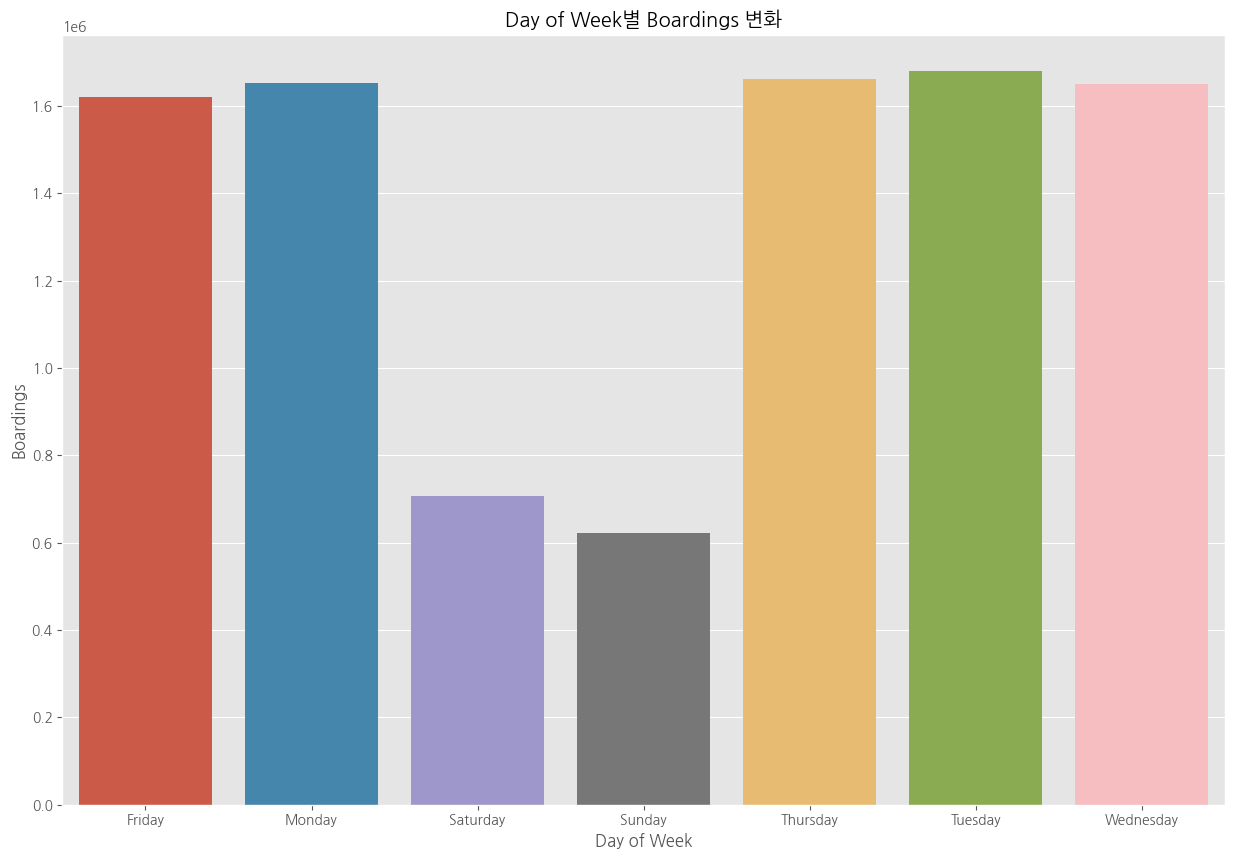

In [188]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Boardings')


* 대기시간

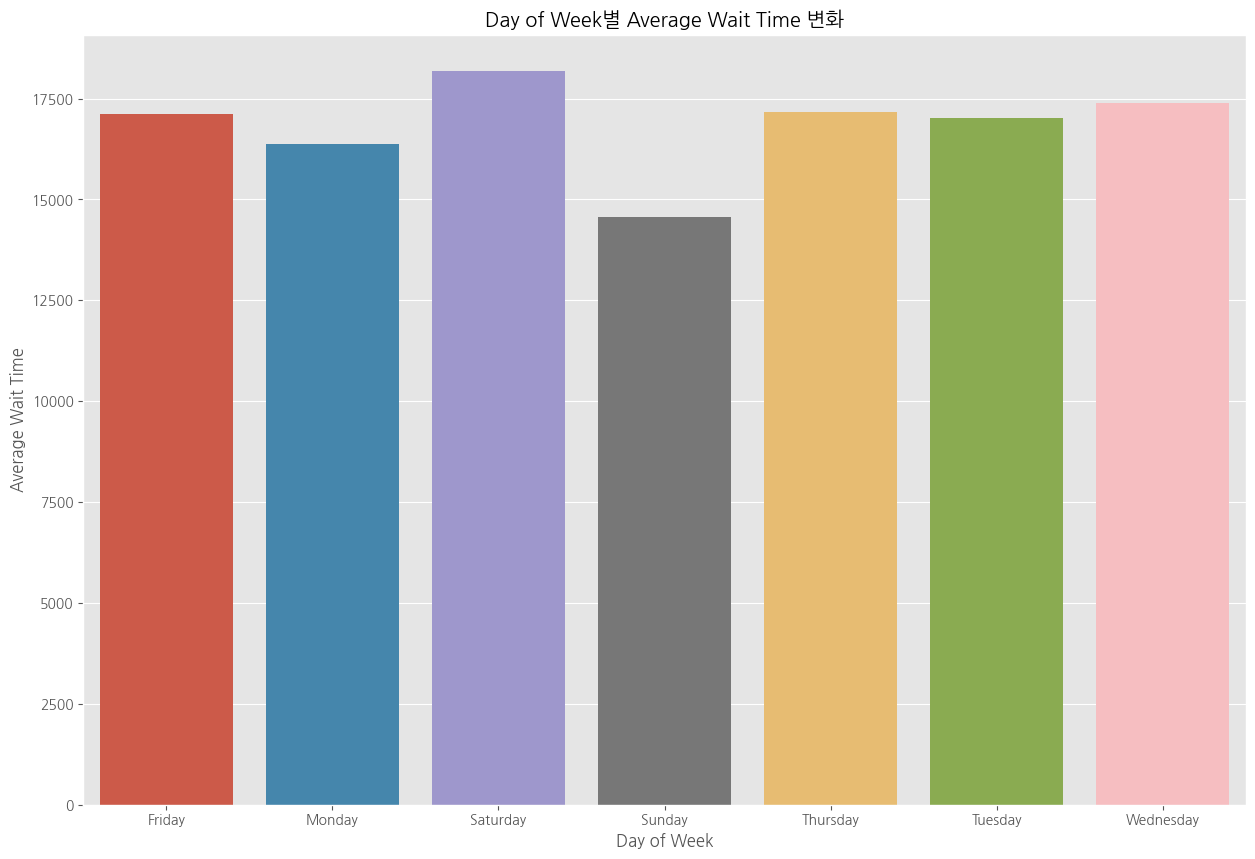

In [189]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Wait Time')


* 운임

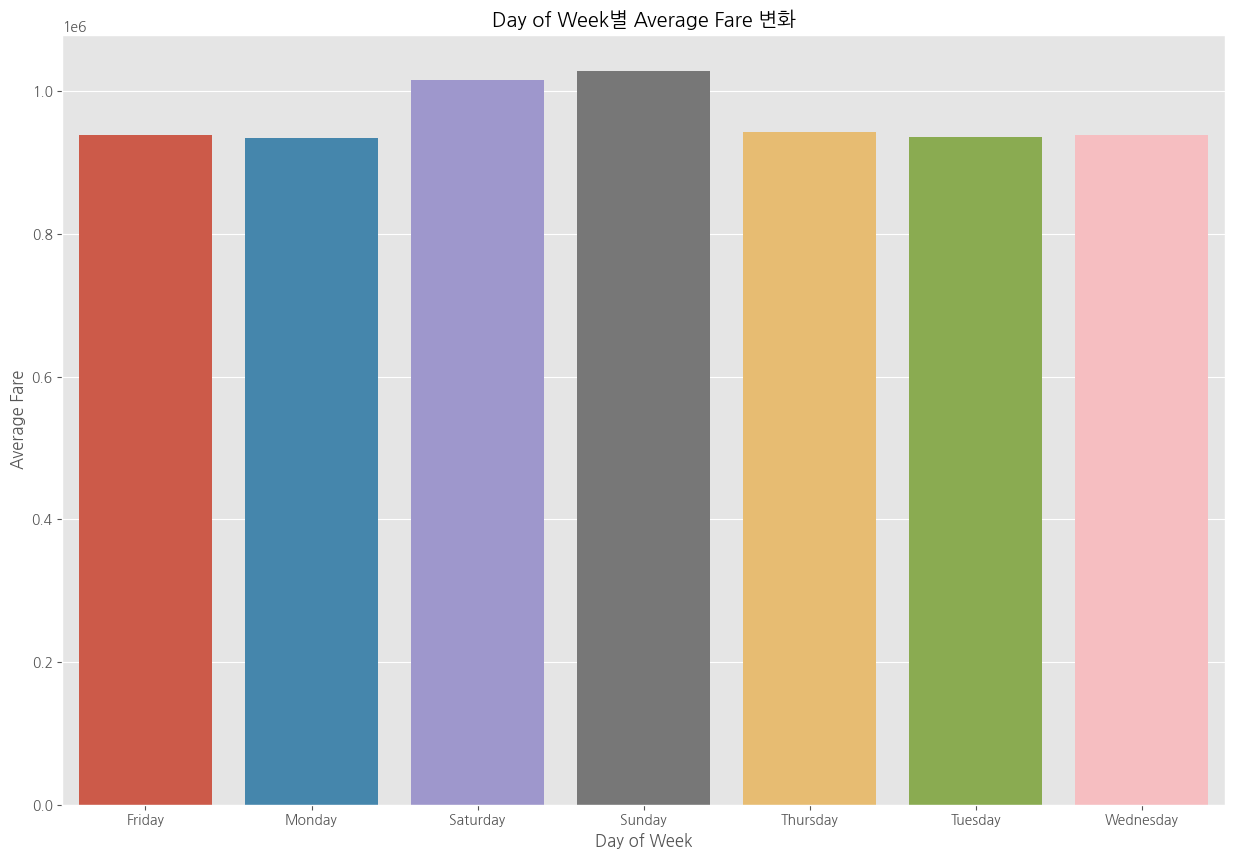

In [190]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Fare')


* 이동거리

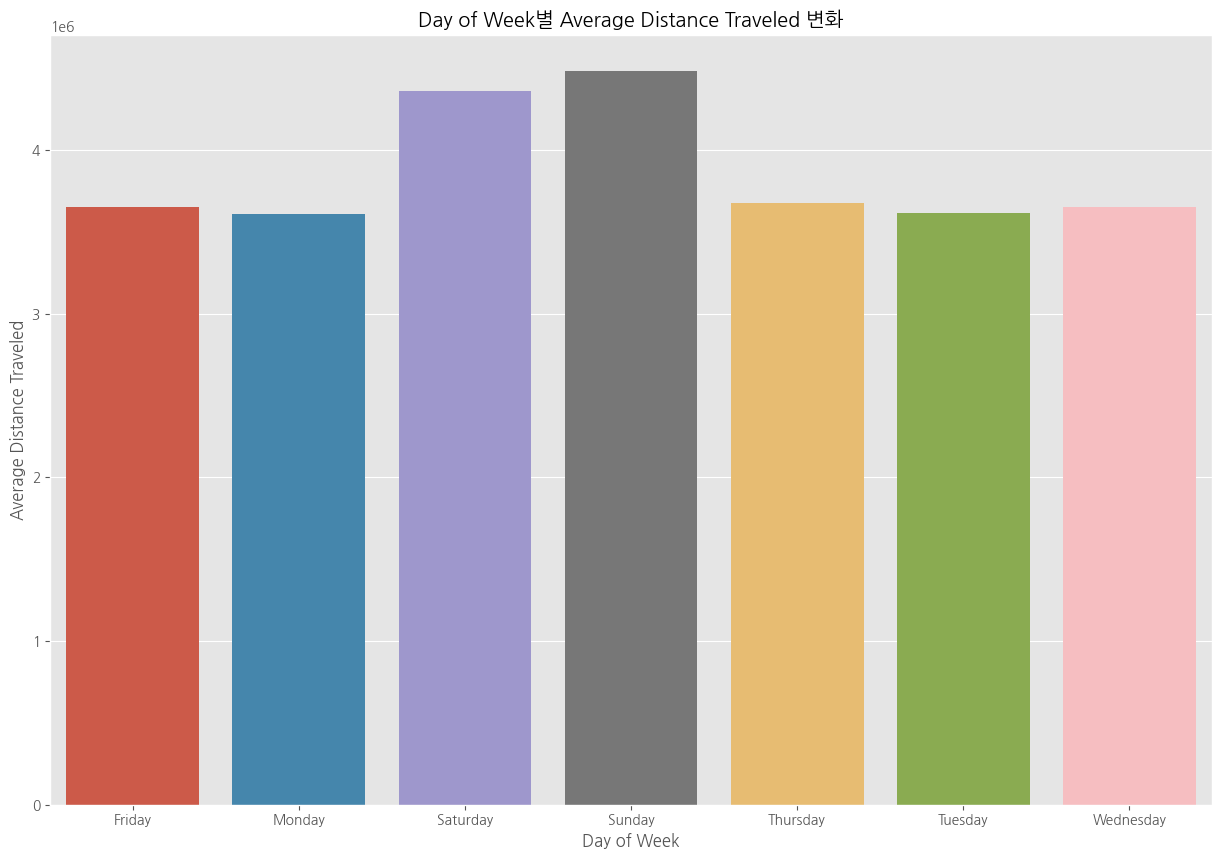

In [191]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Distance Traveled')


### (4) 월별

* 차량 운행수

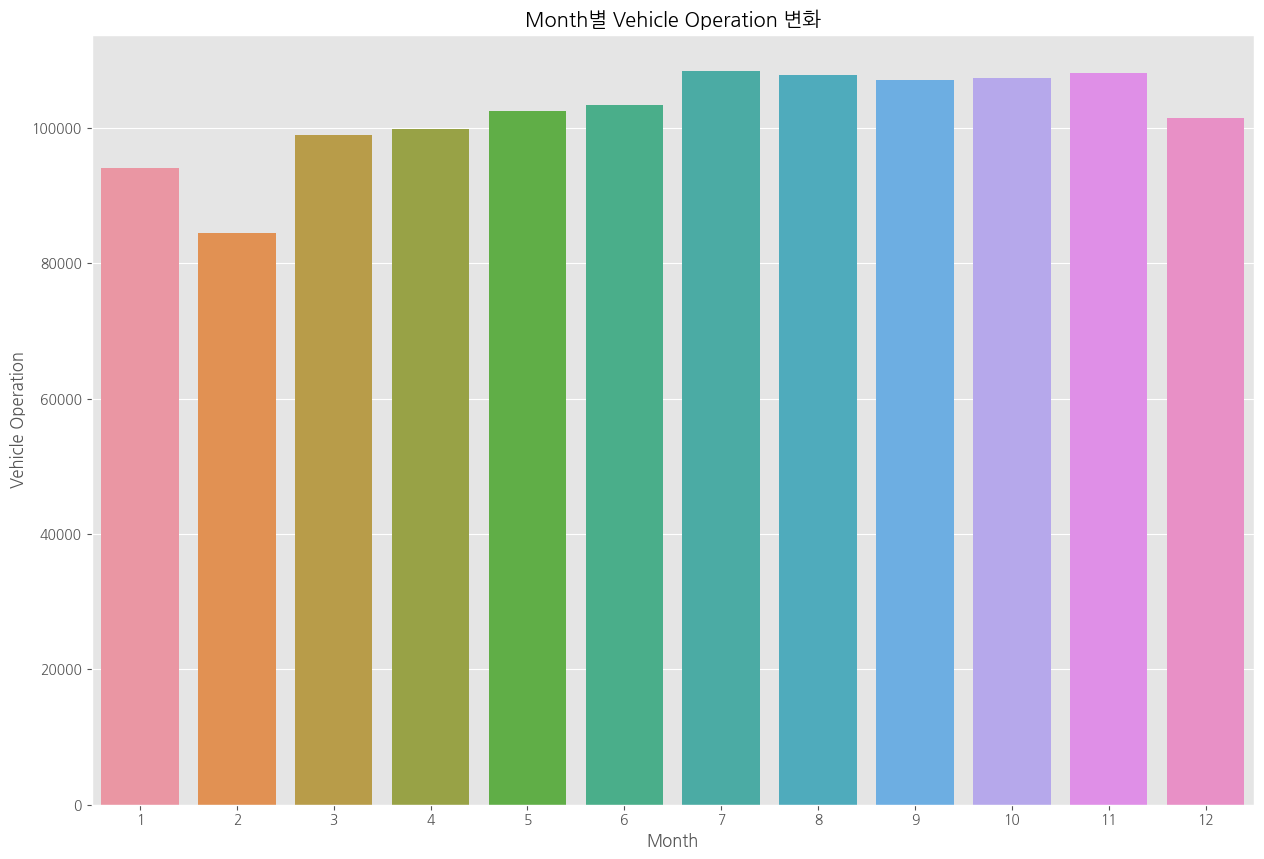

In [192]:
plot_barplot_analysis(taxi_copy, 'Month', 'Vehicle Operation')


* 접수건, 탑승건

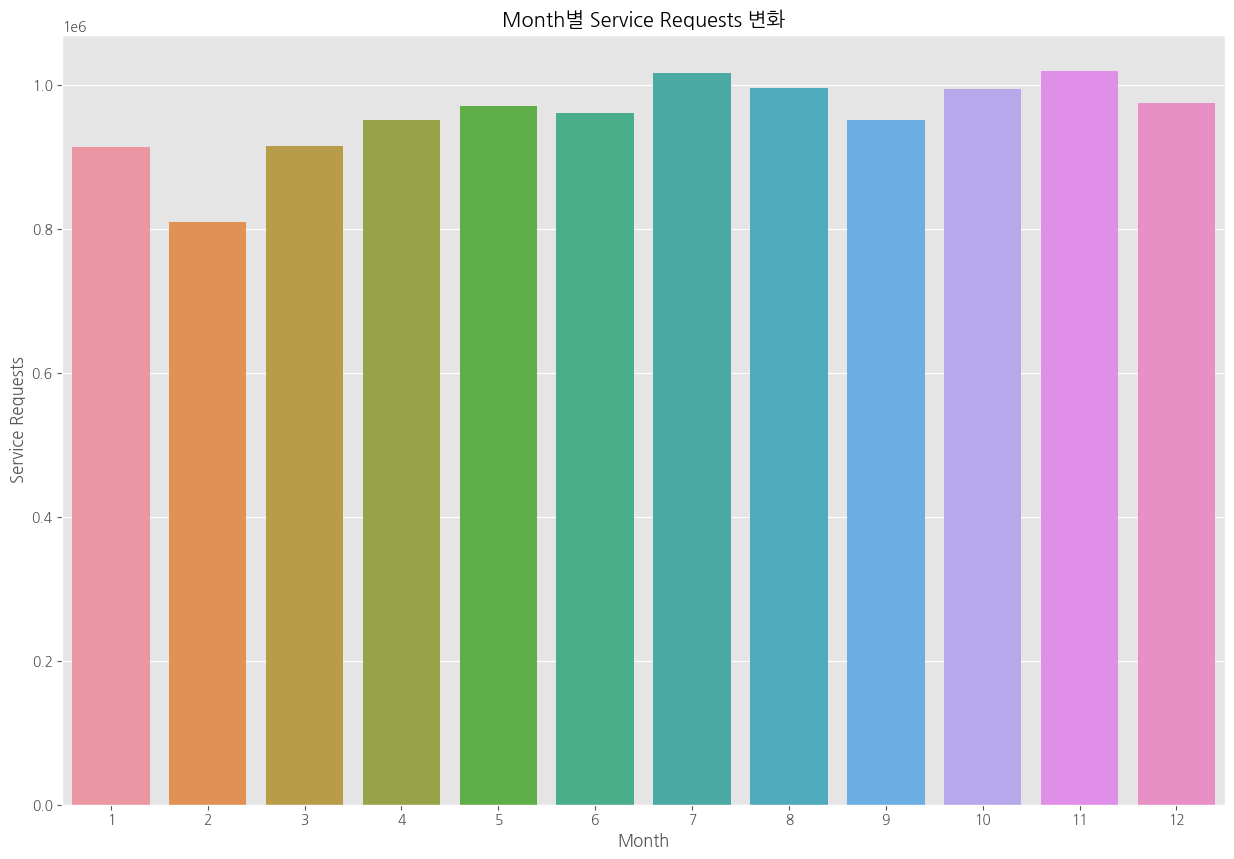

In [193]:
plot_barplot_analysis(taxi_copy, 'Month', 'Service Requests')


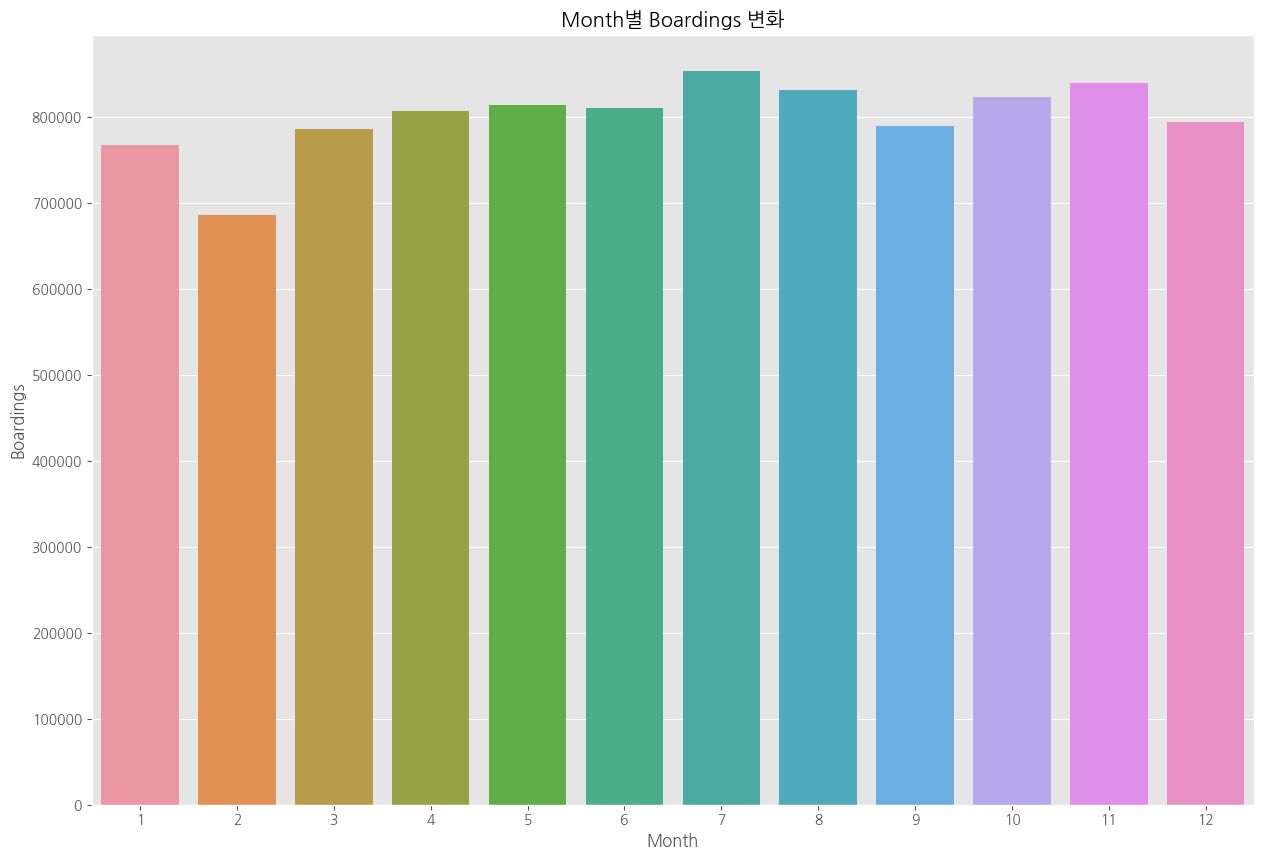

In [194]:
plot_barplot_analysis(taxi_copy, 'Month', 'Boardings')


* 대기시간

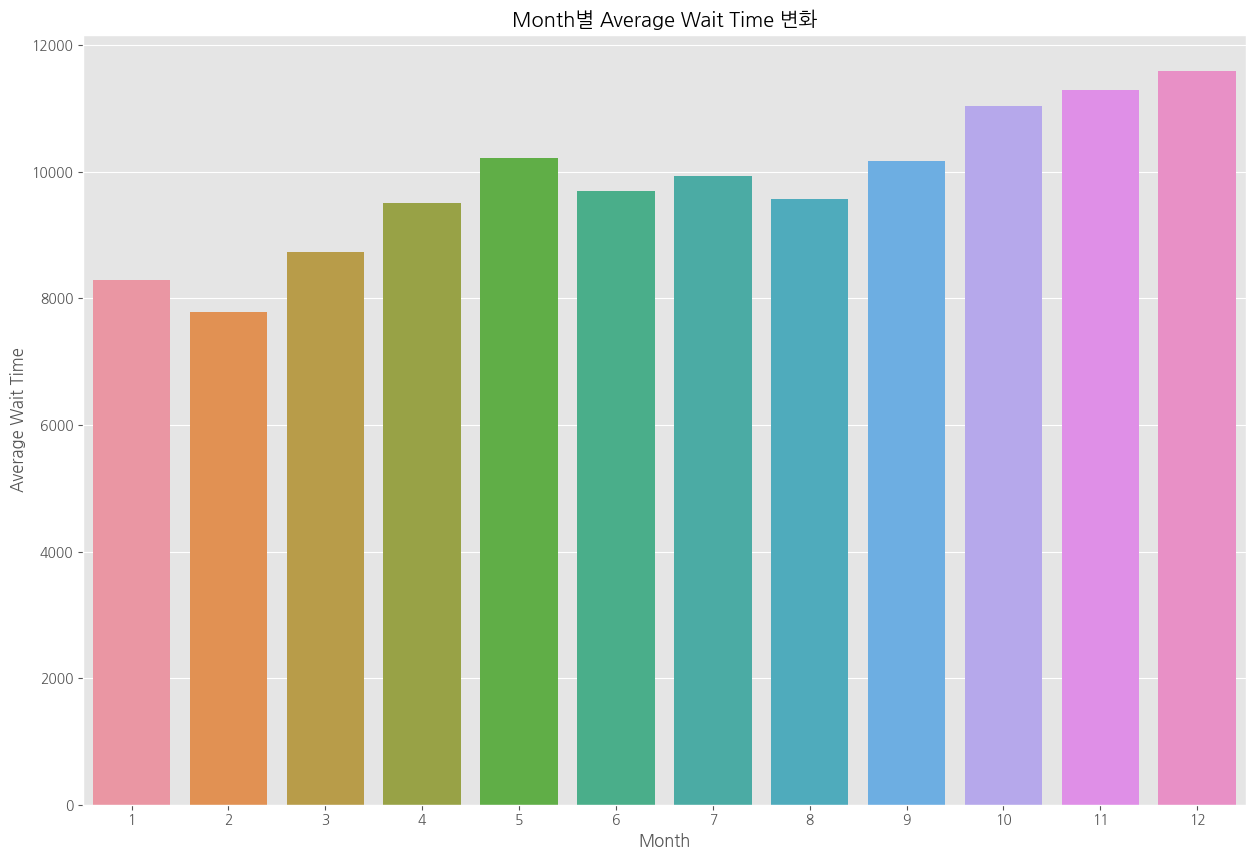

In [195]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Wait Time')


* 운임

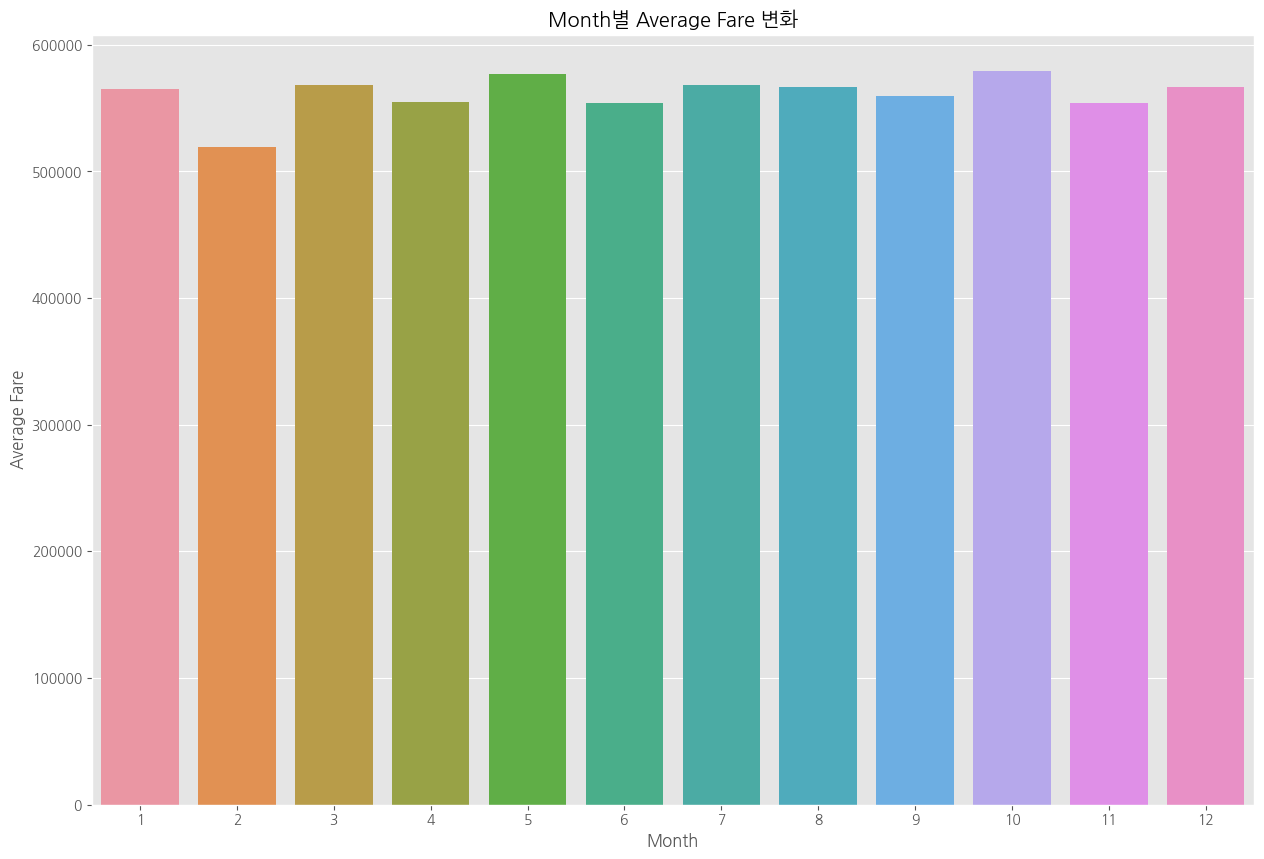

In [196]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Fare')


* 이동거리

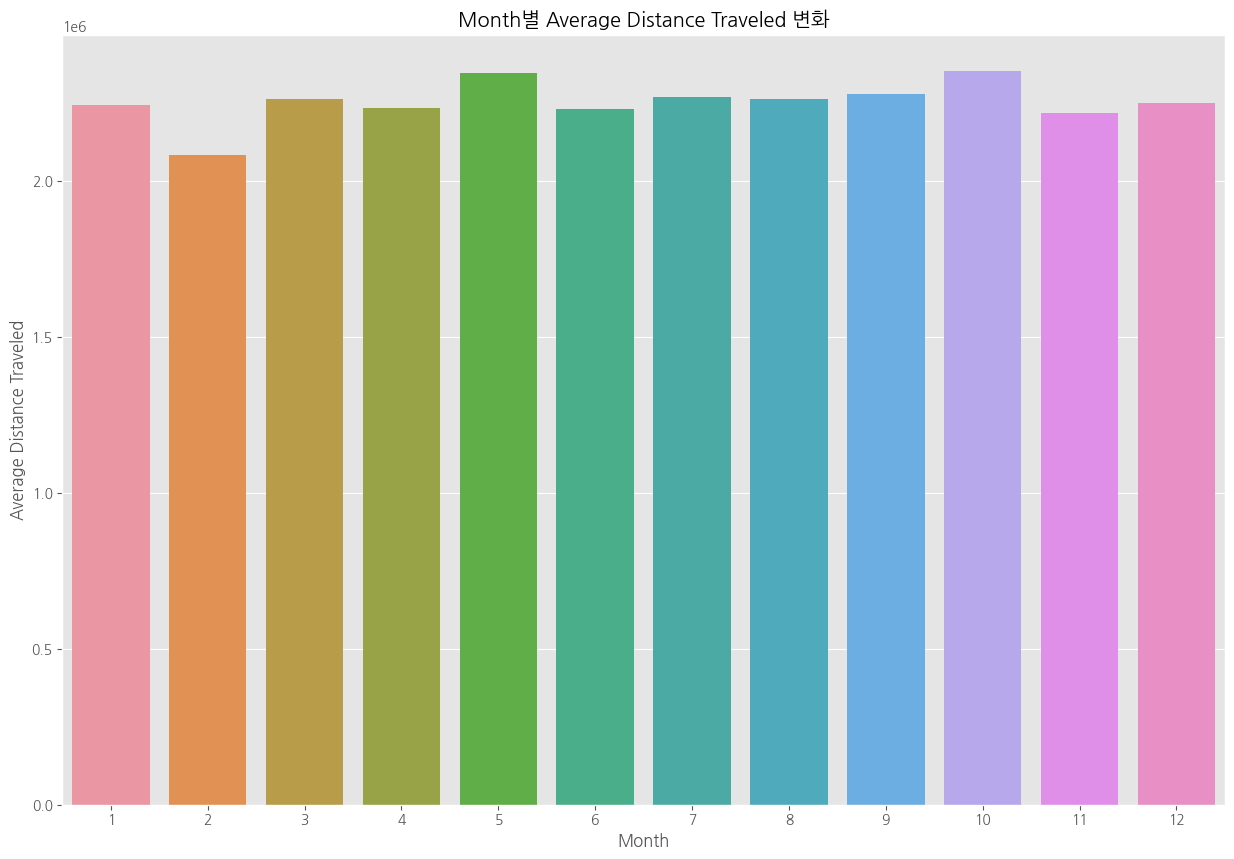

In [197]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Distance Traveled')


### (5) 연도별

* 차량 운행수

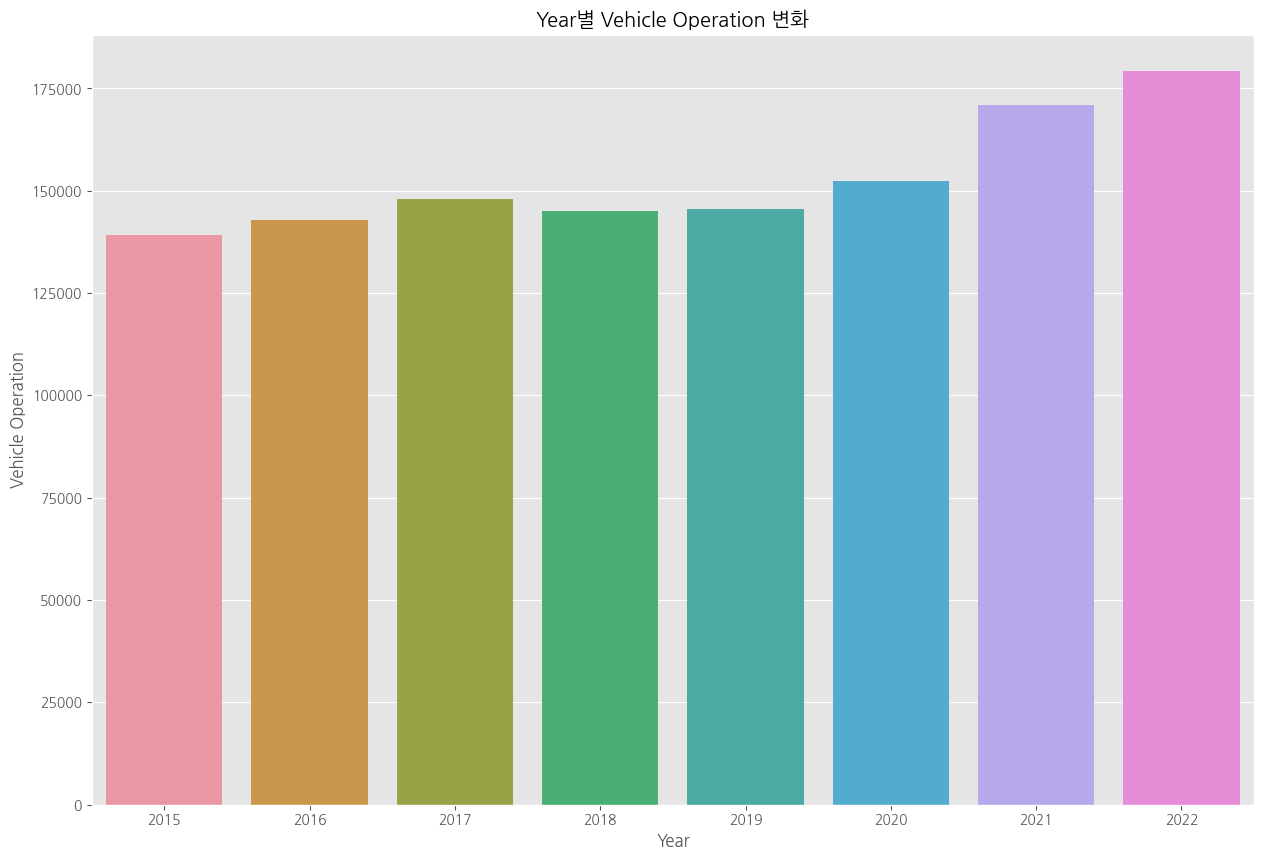

In [198]:
plot_barplot_analysis(taxi_copy, 'Year', 'Vehicle Operation')


* 대기시간

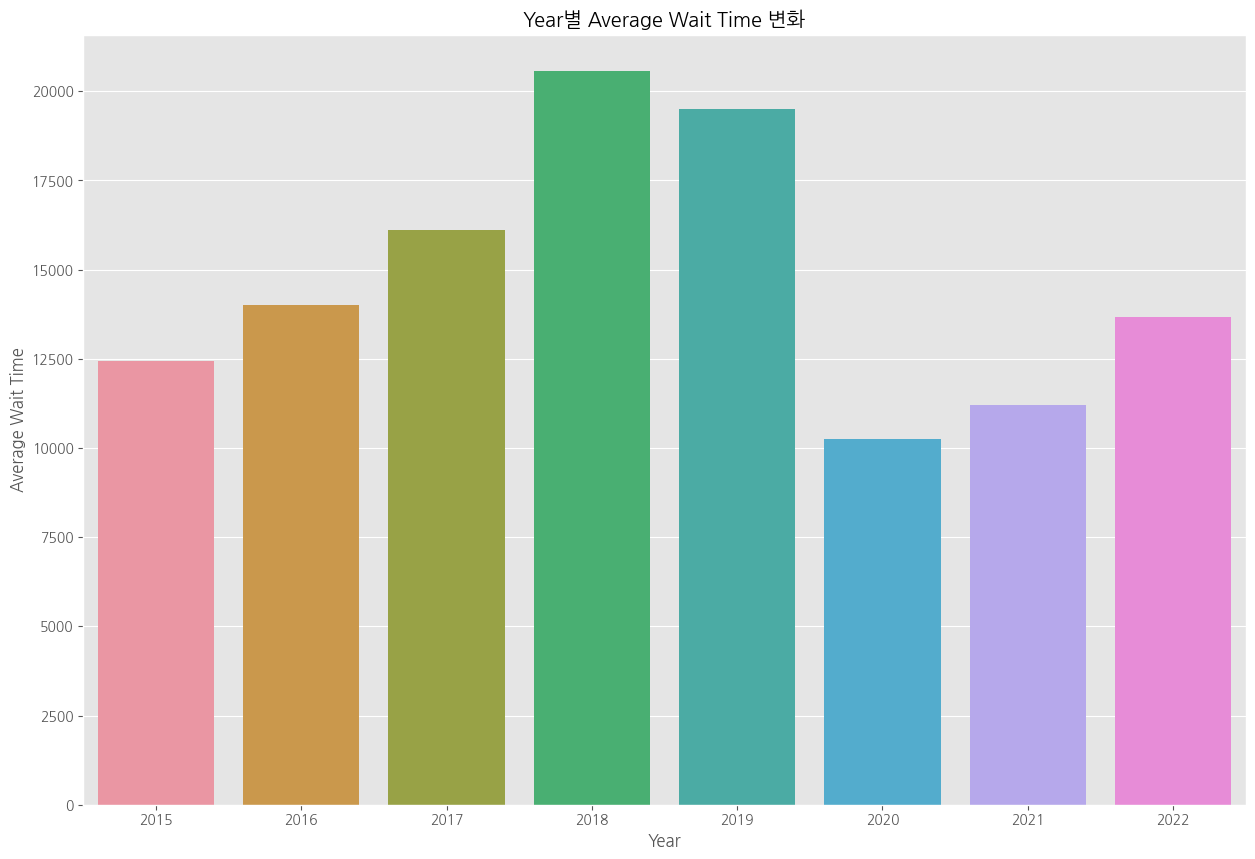

In [199]:
plot_barplot_analysis(taxi_copy, 'Year', 'Average Wait Time')


## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [223]:
weather.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84
4017,2022-12-31,-4.4,-4.4,0.0,66.0,66.0,0.00


In [225]:
# weather df shift 해주기
# Date 열을 datetime 자료형으로 변환
weather['Date'] = pd.to_datetime(weather['Date'])

# 혹시 모르니 사본 복사
weather_shift = weather.copy()

# Date 열의 값을 하루씩 밀기
weather_shift['Date'] = weather_shift['Date'] - pd.DateOffset(days=1)

weather_shift.head()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2011-12-31,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14


### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [203]:
# 예측 대상 날짜 생성 (현재 날짜 + 1일)
taxi_copy['prediction_date'] = taxi_copy['Date'] + pd.Timedelta(days=1)

# 예측하고자 하는 날짜 다음 날의 대기시간을 예측하므로, 예측 날짜 하루 전의 데이터를 사용합니다.
taxi_copy['target'] = taxi_copy['Average Wait Time'].shift(-1)

# target 변수가 float type 이므로, int type 으로 변환합니다.
# taxi_copy['target'] = taxi_copy['target'].astype(int)
# 마지막 날짜에 대한 target은 NaN으로 남게 됩니다. 해당 행 삭제
taxi_copy.dropna(subset=['target'], inplace=True)



In [206]:
taxi_copy.head()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year,prediction_date,target
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,2015,2015-01-02,17.2
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,2015,2015-01-03,26.2
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,2015,2015-01-04,24.5
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,2015,2015-01-05,26.2
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,2015,2015-01-06,23.6


In [207]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2921 non-null   datetime64[ns]
 1   Vehicle Operation          2921 non-null   int64         
 2   Service Requests           2921 non-null   int64         
 3   Boardings                  2921 non-null   int64         
 4   Average Wait Time          2921 non-null   float64       
 5   Average Fare               2921 non-null   int64         
 6   Average Distance Traveled  2921 non-null   int64         
 7   Day of Week                2921 non-null   object        
 8   Week                       2921 non-null   int64         
 9   Month                      2921 non-null   int64         
 10  Year                       2921 non-null   int64         
 11  prediction_date            2921 non-null   datetime64[ns]
 12  target

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [226]:
# 'Date'열을 datetime 자료형으로 변환
weather_shift['Date'] = pd.to_datetime(weather_shift['Date'])

In [231]:
merged_df = pd.merge(taxi_copy, weather_shift, on=['Date'], how='left')

# 병합 결과 확인
merged_df.head()


,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year,prediction_date,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,2015,2015-01-02,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,2015,2015-01-03,26.2,2.4,-9.2,0.0,73.0,37.0,8.66
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,2015,2015-01-04,24.5,8.2,0.2,0.0,89.0,58.0,5.32
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,2015,2015-01-05,26.2,7.9,-0.9,0.0,95.0,52.0,6.48
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,2015,2015-01-06,23.6,4.1,-7.4,3.4,98.0,29.0,10.47


In [210]:
merged_df.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year,prediction_date,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
2916,2022-12-26,603,5555,4605,39.2,2163,7889,Monday,52,12,2022,2022-12-27,44.4,-0.2,-9.5,0.0,81.0,47.0,10.89
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022,2022-12-28,44.8,1.5,-7.9,0.0,85.0,46.0,8.27
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022,2022-12-29,52.5,3.0,-7.3,0.0,86.0,51.0,10.25
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022,2022-12-30,38.3,-0.3,-5.4,0.1,92.0,40.0,10.86
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022,2022-12-31,33.7,1.7,-7.8,0.0,71.0,34.0,10.88


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [232]:
# # 요일 feature 추가
# merged_df['weekday'] = pd.Categorical(merged_df['Date'].dt.weekday_name, categories=
#                                       ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
#                                       ordered=True)

# # 월 feature 추가
# merged_df['month'] = pd.Categorical(merged_df['Date'].dt.month_name(), categories=
#                                     ['January', 'February', 'March', 'April', 'May', 'June', 
#                                      'July', 'August', 'September', 'October', 'November', 'December'],
#                                     ordered=True)

# 계절 feature 추가
seasons = [('winter', [12, 1, 2]), ('spring', [3, 4, 5]), ('summer', [6, 7, 8]), ('fall', [9, 10, 11])]
month_to_season = {month: season for season, months in seasons for month in months}
merged_df['season'] = merged_df['Date'].dt.month.map(month_to_season)

# # 연도 feature 추가
# merged_df['year'] = merged_df['Date'].dt.year


In [233]:
merged_df.head(100)

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year,prediction_date,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,2015,2015-01-02,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,2015,2015-01-03,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,2015,2015-01-04,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,2015,2015-01-05,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,2015,2015-01-06,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-04-06,456,4658,4226,29.0,2244,8926,Monday,15,4,2015,2015-04-07,30.3,11.9,5.7,0.0,68.0,49.0,10.17,spring
96,2015-04-07,462,4679,4256,30.3,2223,8659,Tuesday,15,4,2015,2015-04-08,33.7,13.6,3.7,0.0,73.0,34.0,14.69,spring
97,2015-04-08,458,4718,4199,33.7,2267,9139,Wednesday,15,4,2015,2015-04-09,30.6,16.2,3.8,0.0,62.0,28.0,18.20,spring
98,2015-04-09,458,4720,4223,30.6,2251,9035,Thursday,15,4,2015,2015-04-10,33.3,18.7,4.7,0.0,62.0,21.0,20.67,spring


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [122]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.4 MB/s eta 0:00:00


* 간단 사용법

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [234]:
from datetime import datetime, timedelta
from workalendar.asia import SouthKorea

# workalendar 라이브러리를 사용하여 기본적인 휴무일 데이터를 가져옵니다.
cal = SouthKorea()

# workalendar 라이브러리에 없는 휴무일 데이터를 직접 추가합니다.
custom_holidays = [
    datetime(2017, 5, 9),  # 대통령 선거일
    datetime(2021, 3, 1),  # 3.1절
    datetime(2022, 4, 7),  # 대체공휴일
    datetime(2022, 5, 9)   # 대통령 선거일
]

# 휴무일 데이터를 저장할 데이터셋을 생성합니다.
holidays = []

# 생성한 데이터셋에 휴무일 데이터를 추가합니다.
for year in range(2015, 2023):
    for date, name in cal.holidays(year):
        holiday = {'date': date, 'name': name}
        holidays.append(holiday)
    
    for custom_date in custom_holidays:
        if custom_date.year == year:
            holiday = {'date': custom_date, 'name': 'Custom Holiday'}
            holidays.append(holiday)

# 휴무일 데이터셋을 출력합니다.
for holiday in holidays:
    print(holiday)

# holidays 리스트를 DataFrame으로 변환합니다.
holidays_df = pd.DataFrame(holidays, columns=['date', 'name'])

# Date 컬럼 이름의 첫 글자를 대문자로 변경합니다.
holidays_df = holidays_df.rename(columns={'date': 'Date'})

# 휴무일 데이터셋을 통해 장애인 콜택시의 접수건 변화에 대한 특징을 찾아봅니다.
# 예를 들어, 휴무일이 많은 주차에 장애인 콜택시의 접수건이 적게 발생하는지 확인할 수 있습니다.


{'date': datetime.date(2015, 1, 1), 'name': 'New year'}
{'date': datetime.date(2015, 2, 18), 'name': "Korean New Year's Day"}
{'date': datetime.date(2015, 2, 19), 'name': "Korean New Year's Day"}
{'date': datetime.date(2015, 2, 20), 'name': "Korean New Year's Day"}
{'date': datetime.date(2015, 3, 1), 'name': 'Independence Day'}
{'date': datetime.date(2015, 5, 5), 'name': "Children's Day"}
{'date': datetime.date(2015, 5, 25), 'name': "Buddha's Birthday"}
{'date': datetime.date(2015, 6, 6), 'name': 'Memorial Day'}
{'date': datetime.date(2015, 8, 15), 'name': 'Liberation Day'}
{'date': datetime.date(2015, 9, 26), 'name': 'Midautumn Festival'}
{'date': datetime.date(2015, 9, 27), 'name': 'Midautumn Festival'}
{'date': datetime.date(2015, 9, 28), 'name': 'Midautumn Festival'}
{'date': datetime.date(2015, 10, 3), 'name': 'National Foundation Day'}
{'date': datetime.date(2015, 10, 9), 'name': 'Hangul Day'}
{'date': datetime.date(2015, 12, 25), 'name': 'Christmas Day'}
{'date': datetime.date(2

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [235]:
holidays_df.head()

,Date,name
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day


In [238]:
# 중복값 확인
duplicates = holidays_df[holidays_df['Date'].duplicated(keep=False)]
print(duplicates)


          Date                     name
39  2017-10-03       Midautumn Festival
40  2017-10-03  National Foundation Day
95  2021-03-01         Independence Day
106 2021-03-01           Custom Holiday


In [241]:
# 중복행 삭제, 첫번째 중복행 유지
holidays_df.drop_duplicates(subset='Date', keep='first', inplace=True)


In [242]:
# 다시 확인
duplicates = holidays_df[holidays_df['Date'].duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Date, name]
Index: []


In [243]:
holidays_df['Date'].tolist()[:10]

[Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-02-18 00:00:00'),
 Timestamp('2015-02-19 00:00:00'),
 Timestamp('2015-02-20 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-05-05 00:00:00'),
 Timestamp('2015-05-25 00:00:00'),
 Timestamp('2015-06-06 00:00:00'),
 Timestamp('2015-08-15 00:00:00'),
 Timestamp('2015-09-26 00:00:00')]

In [244]:
# 기존 데이터를 불러옵니다.
df = merged_df.copy()

# 휴무일 데이터를 불러옵니다.
# holidays_df.tail()

# 기존 데이터와 휴무일 데이터를 결합하여 휴무일 여부를 포함한 데이터셋을 생성합니다.
# df['is_holiday'] = df['Date'].apply(lambda x: 1 if x.date() in [holidays_df['Date'].date() for holiday in holidays_df] else 0)
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x.date() in holidays_df['Date'].tolist() else 0)

# 휴무일이 아닌 날짜는 0으로 저장합니다.
df['is_holiday'] = df['is_holiday'].apply(lambda x: x if x == 1 else 0)

# 결과를 확인합니다.
df.head()


<ipython-input-244-d12c452499bd>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df['is_holiday'] = df['Date'].apply(lambda x: 1 if x.date() in holidays_df['Date'].tolist() else 0)


,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,...,prediction_date,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,is_holiday
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,...,2015-01-02,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,1
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,...,2015-01-03,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter,0
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,...,2015-01-04,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter,0
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,...,2015-01-05,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter,0
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,...,2015-01-06,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter,0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

df['Average Wait time']열을 사용해서 7일 간격의 이동평균 값을 계산

In [245]:
# 7일 이동평균 대기시간을 계산합니다.
df['moving_averages_time'] = df['Average Wait Time'].rolling(window=7, min_periods=1).mean()

# 결과를 확인합니다.
df.head()


,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,...,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,is_holiday,moving_averages_time
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,...,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,1,23.200
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,...,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter,0,20.200
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,...,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter,0,22.200
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,...,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter,0,22.775
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,...,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter,0,23.460


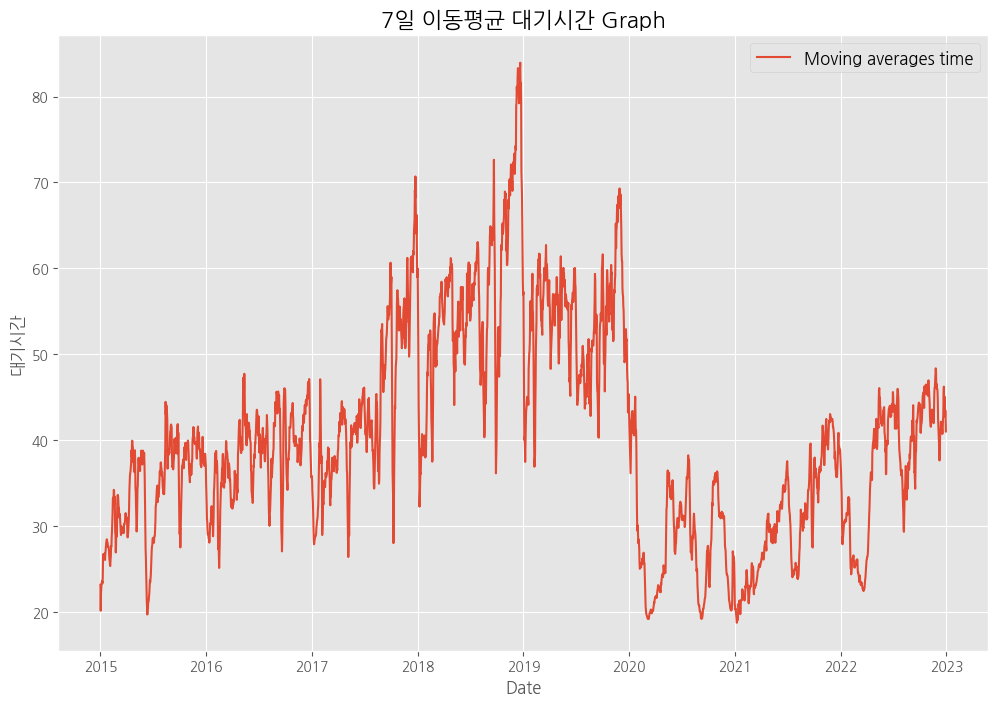

In [246]:
import matplotlib.pyplot as plt

# 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(12, 8))

# 이동평균값을 그래프로 나타내기
ax.plot(df['Date'], df['moving_averages_time'], label='Moving averages time')

# x축과 y축 레이블 설정
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('대기시간', fontsize=12)

# 제목 설정
ax.set_title('7일 이동평균 대기시간 Graph', fontsize=16)

# 범례 추가
ax.legend(fontsize=12)

# 그래프 출력
plt.show()


#### 4) 탑승률

In [249]:
# 7일 이동평균 대기시간을 계산합니다.
df['moving_averages_boardings'] = df['Boardings'].rolling(window=7, min_periods=1).mean()

# 결과를 확인합니다.
df.head()


,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,...,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,is_holiday,moving_averages_time,moving_averages_boardings
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,1,...,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,1,23.200,924.00
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,1,...,2.4,-9.2,0.0,73.0,37.0,8.66,winter,0,20.200,1881.50
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,1,...,8.2,0.2,0.0,89.0,58.0,5.32,winter,0,22.200,1759.00
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,1,...,7.9,-0.9,0.0,95.0,52.0,6.48,winter,0,22.775,1700.75
4,2015-01-05,421,4250,3730,26.2,2214,8663,Monday,2,1,...,4.1,-7.4,3.4,98.0,29.0,10.47,winter,0,23.460,2106.60


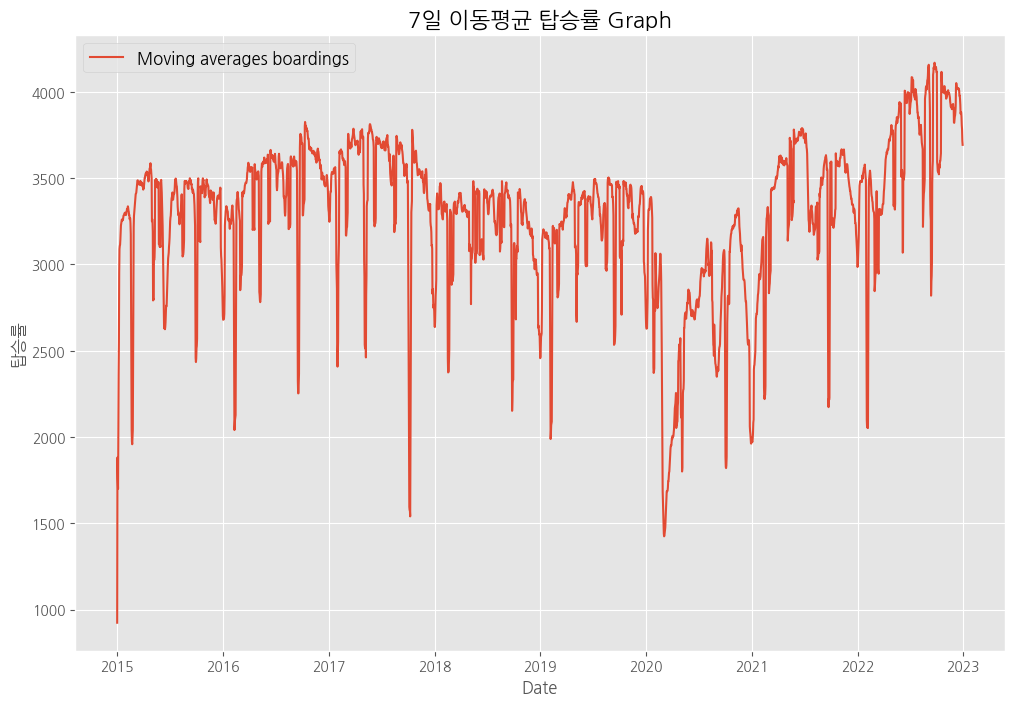

In [250]:
import matplotlib.pyplot as plt

# 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(12, 8))

# 이동평균값을 그래프로 나타내기
ax.plot(df['Date'], df['moving_averages_boardings'], label='Moving averages boardings')

# x축과 y축 레이블 설정
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('탑승률', fontsize=12)

# 제목 설정
ax.set_title('7일 이동평균 탑승률 Graph', fontsize=16)

# 범례 추가
ax.legend(fontsize=12)

# 그래프 출력
plt.show()


## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [251]:
import joblib

joblib.dump(df, path + 'data2.pkl')


['/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/장애인콜택시 대기시간 예측/data2.pkl']